# Perform tethering analysis
- https://pubmed.ncbi.nlm.nih.gov/28945980/
- match PLP pipeline
- extend to multiple labeling
- visualize plate maps and %BPI curves
- depending on system, this analysis is ~10x faster than pipeline pilot

In [2]:
import os
import pandas as pd
import numpy as np

import sys
sys.path.append('/home/apaulson/repos/data-proc/')
import plate_maps as pm
%config Completer.use_jedi=False

In [3]:
%%time
# %debug

# # DATA INPUT # #

# # --------------------------------------- # #
HA_ID=2490
# # --------------------------------------- # #
# # --------------------------------------- # #
barcode=f'SMDC-MPHORE-384-6-01-PT01'
# # --------------------------------------- # #
# # --------------------------------------- # #
pmirm=False # protein mass is reacted mass
cmirm=True # cap mass is reacted mass
rmirm=True # reductant mass is reacted mass
# # --------------------------------------- # #
# # --------------------------------------- # #
scan_range = 5
# # --------------------------------------- # #
# # --------------------------------------- # #
assay_class='HTS'
# # --------------------------------------- # #

infile=r"/Volumes/Shared/SMDC/Screens/2023_users_temp/Saugat/CHIP_E106C_Tau/toload/2490/20231001/SMDC-MPHORE-384-6-01-PT01.rpt"
file=infile.replace("\\","/").replace('Z:','/mnt/z').replace(" ","\\ ").replace("(","\\(").replace(")","\\)")
file=file.replace('{assay}',str(HA_ID))

cmd=f"grep -n '^Sample\s[0-9]' {file} > samples.txt"
os.system(cmd)

cmd=f"grep -n '^Well\s' {file} > wells.txt"
os.system(cmd)

cmd=f"grep -n '^FileName\s' {file} > fnames.txt"
os.system(cmd)

cmd=f"grep -n '^BPM\s' {file} > bpms.txt"
os.system(cmd)

cmd=f"grep -n '^BPI\s' {file} > bpis.txt"
os.system(cmd)

cmd=f"wc -l < {file} > linenum.txt"
os.system(cmd)

cmd=f"grep -n '^\;Mass' {file} > massstart.txt"
os.system(cmd)

search='}'
cmd=fr"grep -n {search} {file} > massend.txt"
os.system(cmd)

samples = pd.read_csv('samples.txt', sep=':', header=None)
wells = pd.read_csv('wells.txt', sep=':', header=None)
fnames = pd.read_csv('fnames.txt', sep=':', header=None)
bpms = pd.read_csv('bpms.txt', sep=':', header=None)
bpis = pd.read_csv('bpis.txt', sep=':', header=None)

samples.columns=['linenum','Sample']
wells.columns=['linenum','Plate','Well']
fnames.columns=['linenum','Fname']
bpms.columns=['linenum','BPM']
bpis.columns=['linenum','BPI']

# samples=samples[~samples.linenum.str.contains('Binary')]
# wells=wells[~wells.linenum.str.contains('Binary')]
# fnames=fnames[~fnames.linenum.str.contains('Binary')]
# bpms=bpms[~bpms.linenum.str.contains('Binary')]
# bpis=bpis[~bpis.linenum.str.contains('Binary')]

# samples.linenum=samples.linenum.astype(int)
# wells.linenum=wells.linenum.astype(int)
# fnames.linenum=fnames.linenum.astype(int)
# bpms.linenum=bpms.linenum.astype(int)
# bpis.linenum=bpis.linenum.astype(int)

samples.Sample=samples.Sample.str.replace('Sample\t','').astype(int)
wells.Plate=wells.Plate.str.replace('Well\t','').astype(int)
fnames.Fname=fnames.Fname.str.replace('FileName\t','')
bpms.BPM=bpms.BPM.str.replace('BPM\t','').astype(float)
bpis.BPI=bpis.BPI.str.replace('BPI\t','').astype(float)

wells['Sample']=np.nan
fnames['Sample']=np.nan
bpms['Sample']=np.nan
bpis['Sample']=np.nan

starts=pd.read_csv('massstart.txt', sep=':', header=None)
starts.columns=['linenum','headers']
# starts=starts[~starts.linenum.str.contains('Binary')]
# starts.linenum=starts.linenum.astype(int)
ends=pd.read_csv('massend.txt', sep=':', header=None)
ends.columns=['linenum','value']
# ends=ends[~ends.linenum.str.contains('Binary')]
# ends.linenum=ends.linenum.astype(int)

starts['Sample']=np.nan
ends['Sample']=np.nan

nl=pd.read_csv('linenum.txt', header=None)
linenum=nl.iloc[0][0]+1

nsamples=len(samples)

for i in range(nsamples):
# for i in [0,1,2]:
    if i==nsamples-1:
        linerange=range(samples.linenum.loc[i], linenum)
    else:
        linerange=range(samples.linenum.loc[i], samples.linenum.loc[i+1]+1)
    sample=samples.Sample.loc[i]
    wells.loc[wells.linenum.isin(linerange), 'Sample']=sample
    fnames.loc[fnames.linenum.isin(linerange), 'Sample']=sample
    bpis.loc[bpis.linenum.isin(linerange), 'Sample']=sample
    bpms.loc[bpms.linenum.isin(linerange), 'Sample']=sample
    starts.loc[starts.linenum.isin(linerange), 'Sample']=sample
    ends.loc[ends.linenum.isin(linerange), 'Sample']=sample

endrows=[]
for i in range(len(starts)):
    if i==len(starts)-1:
        linerange=range(starts.linenum.loc[i], linenum)
    else:
        linerange=range(starts.linenum.loc[i], starts.linenum.loc[i+1]+1)
    tmp=pd.DataFrame(ends[ends.linenum.isin(linerange)].iloc[0]).T
    endrows.append(tmp)
endrows=pd.concat(endrows)

file=infile.replace("\\","/").replace('Z:','/mnt/z')#.replace(" ","\\ ").replace("(","\\(").replace(")","\\)")
file=file.replace('{assay}', str(HA_ID))
with open(file, "rb") as f:
    content=f.readlines()

CPU times: user 986 ms, sys: 65.4 ms, total: 1.05 s
Wall time: 13.3 s


In [4]:
df=samples.merge(wells, how='left', on='Sample', suffixes=['_sample','_well'])
df=df.merge(fnames, how='left', on='Sample')
df=df.merge(bpis, how='left', on='Sample', suffixes=['_fname','_bpi'])
df=df.merge(bpms, how='left', on='Sample')
df=df.merge(starts, how='left', on='Sample', suffixes=['_bpm','_start'])
df=df.merge(endrows, how='left', on='Sample')
df=df[['Sample', 'Plate', 'Well', 'Fname', 'BPI', 'BPM', 'linenum_start', 'linenum']]
df.columns=['Sample', 'Plate', 'Well', 'Fname', 'intensitymax', 'massatmax', 'linenum_start', 'linenum']
df.linenum_start=df.linenum_start.replace(np.nan, -99).astype(int)
# df.linenum=df.linenum.replace(.astype(int)

for i, row in df.iterrows():
    if row.linenum_start==-99:
        continue
    samplefile=f'Sample_{str(row.Sample).zfill(3)}_data.txt'
    with open(samplefile, "wb") as f:
        f.writelines(content[row.linenum_start-1:row.linenum-1])

# %%time
# # DATA ANALYSIS # #

# lookup info in db for assay and plate

query1=f"""SELECT
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID} AND HAPA_HAPAT_ID = 57 AND HAPA_STATUS_ID = 1) AS 'site_count',
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID} AND HAPA_HAPAT_ID = 53 AND HAPA_STATUS_ID = 1) AS 'protein_mass',
(SELECT HAPA_VALUE
FROM HTS_ASSAY_PARAMETER
INNER JOIN HTS_ASSAY ON HA_ID = HAPA_HA_ID
WHERE HA_ID = {HA_ID}  AND HAPA_HAPAT_ID = 54 AND HAPA_STATUS_ID = 1) AS 'reductant_mass',
(SELECT HA_ID
FROM HTS_ASSAY
WHERE HA_ID = {HA_ID}) AS HA_ID"""
query2=f"""
SELECT IP_ID, IW_ID, ICL_IC_ID, ICL_ID, GROUP_CONCAT(ICAF_FEATURE SEPARATOR ";") AS adduct_mass
FROM INV_WELL
LEFT OUTER JOIN INV_COMP_LOT ON IW_ICL_ID = ICL_ID
LEFT OUTER JOIN INV_PLATE ON IP_ID = IW_IP_ID
LEFT OUTER JOIN INV_COMP_ANNOT ON ICL_IC_ID = ICA_IC_ID AND ICA_ICAT_ID =  8
LEFT OUTER JOIN INV_COMP_ANNOT_FEATURE ON ICAF_ICA_ID = ICA_ID
WHERE IP_BARCODE = '{barcode}'
GROUP BY IW_ID"""
query3=f"""
SELECT IP_ID, IW_ID, IW_COORDINATES as Well, ICL_IC_ID, ICL_ID, GROUP_CONCAT(ICAF_FEATURE SEPARATOR ";") AS cap_mass
FROM INV_WELL
LEFT OUTER JOIN INV_COMP_LOT ON IW_ICL_ID = ICL_ID
LEFT OUTER JOIN INV_PLATE ON IP_ID = IW_IP_ID
LEFT OUTER JOIN INV_COMP_ANNOT ON ICL_IC_ID = ICA_IC_ID AND ICA_ICAT_ID =  13
LEFT OUTER JOIN INV_COMP_ANNOT_FEATURE ON ICAF_ICA_ID = ICA_ID
WHERE IP_BARCODE = '{barcode}'
GROUP BY IW_ID"""

cnx = pm.create_mysql_cnx()
nums=pd.read_sql(query1, cnx)
adds=pd.read_sql(query2,cnx)
caps=pd.read_sql(query3,cnx)
cnx.dispose()

addcaps=adds.merge(caps)

hydrogen = 1.007825

protein_mass = nums.protein_mass.astype(float).iloc[0]
site_count = nums.site_count.astype(float).iloc[0]
reductant_mass = nums.reductant_mass.astype(float).iloc[0]

if pmirm:
    protein_mass=protein_mass+hydrogen # add hydrogen to get free protein mass
if not cmirm:
    caps.cap_mass=caps.cap_mass-hydrogen # remove hydrogen to get reacted mass
if not rmirm:
    reductant_mass=reductant_mass-hydrogen # remove hydrogen to get reacted mass

# free protein
free_protein_min=protein_mass-scan_range
free_protein_max=protein_mass+scan_range
# remove hydrogen again
protein_mass=protein_mass-hydrogen

# throw error if adduct_mass not defined
print(f"Adduct mass is not defined for {sum(addcaps.adduct_mass.isna())} rows.")
addcaps=addcaps[~addcaps.adduct_mass.isna()]
addcaps=addcaps[~addcaps.adduct_mass.astype(str).str.contains(';')]

# protein-adduct
addcaps['protein_1adduct_min']=protein_mass+addcaps.adduct_mass.astype(float)-scan_range
addcaps['protein_1adduct_max']=protein_mass+addcaps.adduct_mass.astype(float)+scan_range
#protein-reductant
addcaps['protein_1reductant_min']=protein_mass+reductant_mass-scan_range
addcaps['protein_1reductant_max']=protein_mass+reductant_mass+scan_range
#protein-cap
addcaps['protein_1cap_min']=protein_mass+addcaps.cap_mass.astype(float)-scan_range
addcaps['protein_1cap_max']=protein_mass+addcaps.cap_mass.astype(float)+scan_range

# two binding sites
if site_count >1:
    # TODO: add checks for adduct mass existence
    # protein + 2 adduct
    addcaps['protein_2adduct_min']=protein_mass + 2*addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_2adduct_max']=protein_mass + 2*addcaps.adduct_mass.astype(float) + scan_range
    # protein + adduct + cap
    addcaps['protein_1adduct_1cap_min'] = protein_mass + addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1adduct_1cap_max'] = protein_mass + addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) + scan_range
    # protein + adduct + reductant
    addcaps['protein_1reductant_1adduct_min'] = protein_mass + reductant_mass + addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_1reductant_1adduct_max'] = protein_mass + reductant_mass + addcaps.adduct_mass.astype(float) + scan_range
    # protein + 2 reductant
    addcaps['protein_2reductant_min'] = protein_mass + 2*reductant_mass - scan_range
    addcaps['protein_2reductant_max'] = protein_mass + 2*reductant_mass + scan_range
    # protein + reductant + cap
    addcaps['protein_1reductant_1cap_min'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1reductant_1cap_max'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) + scan_range
    # protein + 2 cap
    addcaps['protein_2cap_min'] = protein_mass + 2*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_2cap_max'] = protein_mass + 2*addcaps.cap_mass.astype(float) + scan_range
    
    
    # protein + 3 adduct
    addcaps['protein_3adduct_min']=protein_mass + 3*addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_3adduct_max']=protein_mass + 3*addcaps.adduct_mass.astype(float) + scan_range
    
    # protein + adduct + cap
    addcaps['protein_2adduct_1cap_min'] = protein_mass + 2*addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_2adduct_1cap_max'] = protein_mass + 2*addcaps.adduct_mass.astype(float) + addcaps.cap_mass.astype(float) + scan_range
    
    addcaps['protein_1adduct_2cap_min'] = protein_mass + addcaps.adduct_mass.astype(float) + 2*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1adduct_2cap_max'] = protein_mass + addcaps.adduct_mass.astype(float) + 2*addcaps.cap_mass.astype(float) + scan_range
    
    # protein + adduct + reductant
    addcaps['protein_2reductant_1adduct_min'] = protein_mass + 2*reductant_mass + addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_2reductant_1adduct_max'] = protein_mass + 2*reductant_mass + addcaps.adduct_mass.astype(float) + scan_range
    
    addcaps['protein_1reductant_2adduct_min'] = protein_mass + reductant_mass + 2*addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_1reductant_2adduct_max'] = protein_mass + reductant_mass + 2*addcaps.adduct_mass.astype(float) + scan_range
    
    # protein + adduct + cap + reductant
    addcaps['protein_1adduct_1cap_1reductant_min'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) + addcaps.adduct_mass.astype(float) - scan_range
    addcaps['protein_1adduct_1cap_1reductant_max'] = protein_mass + reductant_mass + addcaps.cap_mass.astype(float) + addcaps.adduct_mass.astype(float) + scan_range
    
    # protein + 3 reductant
    addcaps['protein_3reductant_min'] = protein_mass + 3*reductant_mass - scan_range
    addcaps['protein_3reductant_max'] = protein_mass + 3*reductant_mass + scan_range
    
    # protein + reductant + cap
    addcaps['protein_2reductant_1cap_min'] = protein_mass + 2*reductant_mass + addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_2reductant_1cap_max'] = protein_mass + 2*reductant_mass + addcaps.cap_mass.astype(float) + scan_range
    
    addcaps['protein_1reductant_2cap_min'] = protein_mass + reductant_mass + 2*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_1reductant_2cap_max'] = protein_mass + reductant_mass + 2*addcaps.cap_mass.astype(float) + scan_range
    
    # protein + 3 cap
    addcaps['protein_3cap_min'] = protein_mass + 3*addcaps.cap_mass.astype(float) - scan_range
    addcaps['protein_3cap_max'] = protein_mass + 3*addcaps.cap_mass.astype(float) + scan_range
    
df[['string']]=''
df[['protein','protein_adduct','protein_secondary','protein_2adduct','protein_3adduct','well_sum','well_cnt']]=0

df[['row','col']]=df.Well.str.split(',', expand=True)
df.Well=df.row+df.col.str.zfill(2)

addcaps['Plate']=df.Plate.iloc[0]
df=df.merge(addcaps, how='left')

rows=[]
for i, row in df.iterrows():
    if row.linenum_start==-99:
        continue
    # read raw data
    file=f'Sample_{str(row.Sample).zfill(3)}_data.txt'
    dat=pd.read_csv(file, sep='\t')
    dat.columns=['mass', 'intensity']
    # create string annot of dat
    dat['string']=pd.cut(dat.intensity, [-1., 10.5, 30., 50., 70., 100., 200.], labels=['','.','-','i','l','!'])
    row.string=''.join(dat.string)
    
    # add protein intensities, remove from dat
    # protein with no adduct
    tmp=dat[(dat.mass.between(row.protein_1cap_min, row.protein_1cap_max))|(dat.mass.between(free_protein_min, free_protein_max))|(dat.mass.between(row.protein_1reductant_min, row.protein_1reductant_max))]
    row.protein=tmp.intensity.sum()
    dat=dat[~dat.index.isin(tmp.index)]
    # add (Single) tethered intensities, remove from dat
    tmp=dat[dat.mass.between(row.protein_1adduct_min, row.protein_1adduct_max)]
    row.protein_adduct=tmp.intensity.sum()
    dat=dat[~dat.index.isin(tmp.index)]
    # add secondary labeling intensities, remove from dat
    if site_count>1:
        # 2caps, 2reds, 1cap1red (not labeled)
        tmp=dat[(dat.mass.between(row.protein_2cap_min, row.protein_2cap_max))|(dat.mass.between(row.protein_2reductant_min, row.protein_2reductant_max))|(dat.mass.between(row.protein_1reductant_1cap_min, row.protein_1reductant_1cap_max))]
        row.protein=row.protein+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # adduct-cap, adduct-red (single labeled at either spot)
        tmp=dat[(dat.mass.between(row.protein_1adduct_1cap_min,row.protein_1adduct_1cap_max))|(dat.mass.between(row.protein_1reductant_1adduct_min,row.protein_1reductant_1adduct_max))]
        row.protein_adduct=row.protein_adduct+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # adduct-adduct (double labeled at max 2 spots)
        tmp=dat[(dat.mass.between(row.protein_2adduct_min,row.protein_2adduct_min))]
        row.protein_2adduct=tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        
        # 3 caps, 3 reds, 2 cap 1 red, 2 red 1 cap (no label)
        tmp=dat[(dat.mass.between(row.protein_3cap_min,row.protein_3cap_max))|(dat.mass.between(row.protein_3reductant_min, row.protein_3reductant_max))|
                (dat.mass.between(row.protein_2reductant_1cap_min, row.protein_2reductant_1cap_max))|(dat.mass.between(row.protein_1reductant_2cap_min, row.protein_1reductant_2cap_max))]
        row.protein=row.protein+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # 1adduct-2cap, 1adduct-2red, 1adduct-1cap-1red (single)
        tmp=dat[(dat.mass.between(row.protein_1adduct_2cap_min, row.protein_1adduct_2cap_max))|(dat.mass.between(row.protein_2reductant_1adduct_min, row.protein_2reductant_1adduct_max))|
                (dat.mass.between(row.protein_1adduct_1cap_1reductant_min,row.protein_1adduct_1cap_1reductant_max))]
        row.protein_adduct=row.protein_adduct+tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # 2adduct-1cap, 2adduct-1red (double)
        tmp=dat[(dat.mass.between(row.protein_2adduct_1cap_min, row.protein_2adduct_1cap_max))|(dat.mass.between(row.protein_1reductant_2adduct_min, row.protein_1reductant_2adduct_max))]
        row.protein_2adduct=tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
        # 3 adduct (triple)
        tmp=dat[(dat.mass.between(row.protein_3adduct_min, row.protein_3adduct_max))]
        row.protein_3adduct=tmp.intensity.sum()
        dat=dat[~dat.index.isin(tmp.index)]
                 
    # add max intensities if elsewhere, remove from dat (labeling at max intensity spot ignoring where it should be labeled)
    tmp=dat[dat.mass.between(row.massatmax-scan_range, row.massatmax+scan_range)]
    row.protein_secondary=tmp.intensity.sum()
    dat=dat[~dat.index.isin(tmp.index)]
    # add residual signal (background or other labeling)
    row.well_sum=dat.intensity.sum()
    row.well_cnt=len(dat)
    rows.append(pd.DataFrame(row).T)
df=pd.concat(rows)

# rename columns
df=df.rename(columns={
    'string':'intensityprint',
    'protein':'intensityprotein',            # sum of protein unlabeled peak (s) - unlabled single, unlabeled cap cap, unlabeled red red, unlabeled cap red
    'protein_adduct':'intensitytethered',    # sum of protein single labeled peak (s) - single label only, single + reductant, single + cap
    'protein_secondary':'intensitysecondary',# sum of protein at maximum intensity peak regardless of where it's expected
    'protein_2adduct':'intensitydoubletethered', # sum of protein at double labeled peaks
    'protein_3adduct':'intensitytripletethered', # sum of protein at triple labeled peaks
})

well_sum=df.well_sum.sum()                   # sum of all residual signal across all wells
well_cnt=df.well_cnt.sum()                   # sum of number of measured points contributing to residual signal across all wells

# calculate total (expected) intensity
df['intensitytotal']=df.intensityprotein+df.intensitytethered+df.intensitydoubletethered+df.intensitytripletethered

# calc percentages

# real labeling at expected masses (ignoring any secondary peak)
df['percentlabeled']=(df.intensitytethered+df.intensitydoubletethered+df.intensitytripletethered)/df.intensitytotal*100

# only filter if AssayClass is 'HighThroughputAssay' not dose response
if assay_class == 'HTS':
    df['note']=''
    df.loc[df.percentlabeled>=1,'note']='Percent labeled > 1'
    df.loc[df.percentlabeled<0.001,'note']='Percent labeled < 0.001'

# secondary mass that doesn't represent expected mass peaks
df['percentsecondary']=df.intensitysecondary/(df.intensitytotal+df.intensitysecondary)*100

# single labeling at expected mass
df['percentsinglelabeled']=df.intensitytethered/(df.intensitytotal)*100

# percent double labeled at expected masses
if site_count>1:
    df['percentdoublelabeled']=df.intensitydoubletethered/(df.intensitytotal)*100
    df['percenttriplelabeled']=df.intensitytripletethered/(df.intensitytotal)*100

# ignore secondary peak if it's smaller than bound protein peak
df.loc[df.percentsecondary<df.percentlabeled, 'percentsecondary']=0
df.loc[df.percentsecondary<df.percentlabeled, 'spectrashift']=0
# otherwise note spectra shift (delta in mass of max intensity peak vs protein alone peak
df.loc[df.percentsecondary>=df.percentlabeled, 'spectrashift']=df.loc[df.percentsecondary>=df.percentlabeled, 'massatmax']-protein_mass

# what percentage of peaks were binned meaningfully?
# ratio of expected mass intensity to well total sum
# intensity of all peaks noted / all peaks noted plus extra signal
df['signalsignificance']=100*(df.intensitytotal+df.intensitysecondary)/(df.well_sum+df.intensitytotal+df.intensitysecondary)
# TODO: remove properties before insertion into db? "protein", "protein_adduct", "protein_secondary", "protein_2adduct", "well_sum", "mass", "intensity"

Adduct mass is not defined for 144 rows.


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
df.Plate.unique()

array([1], dtype=object)

In [6]:
barcode

'SMDC-MPHORE-384-6-01-PT01'

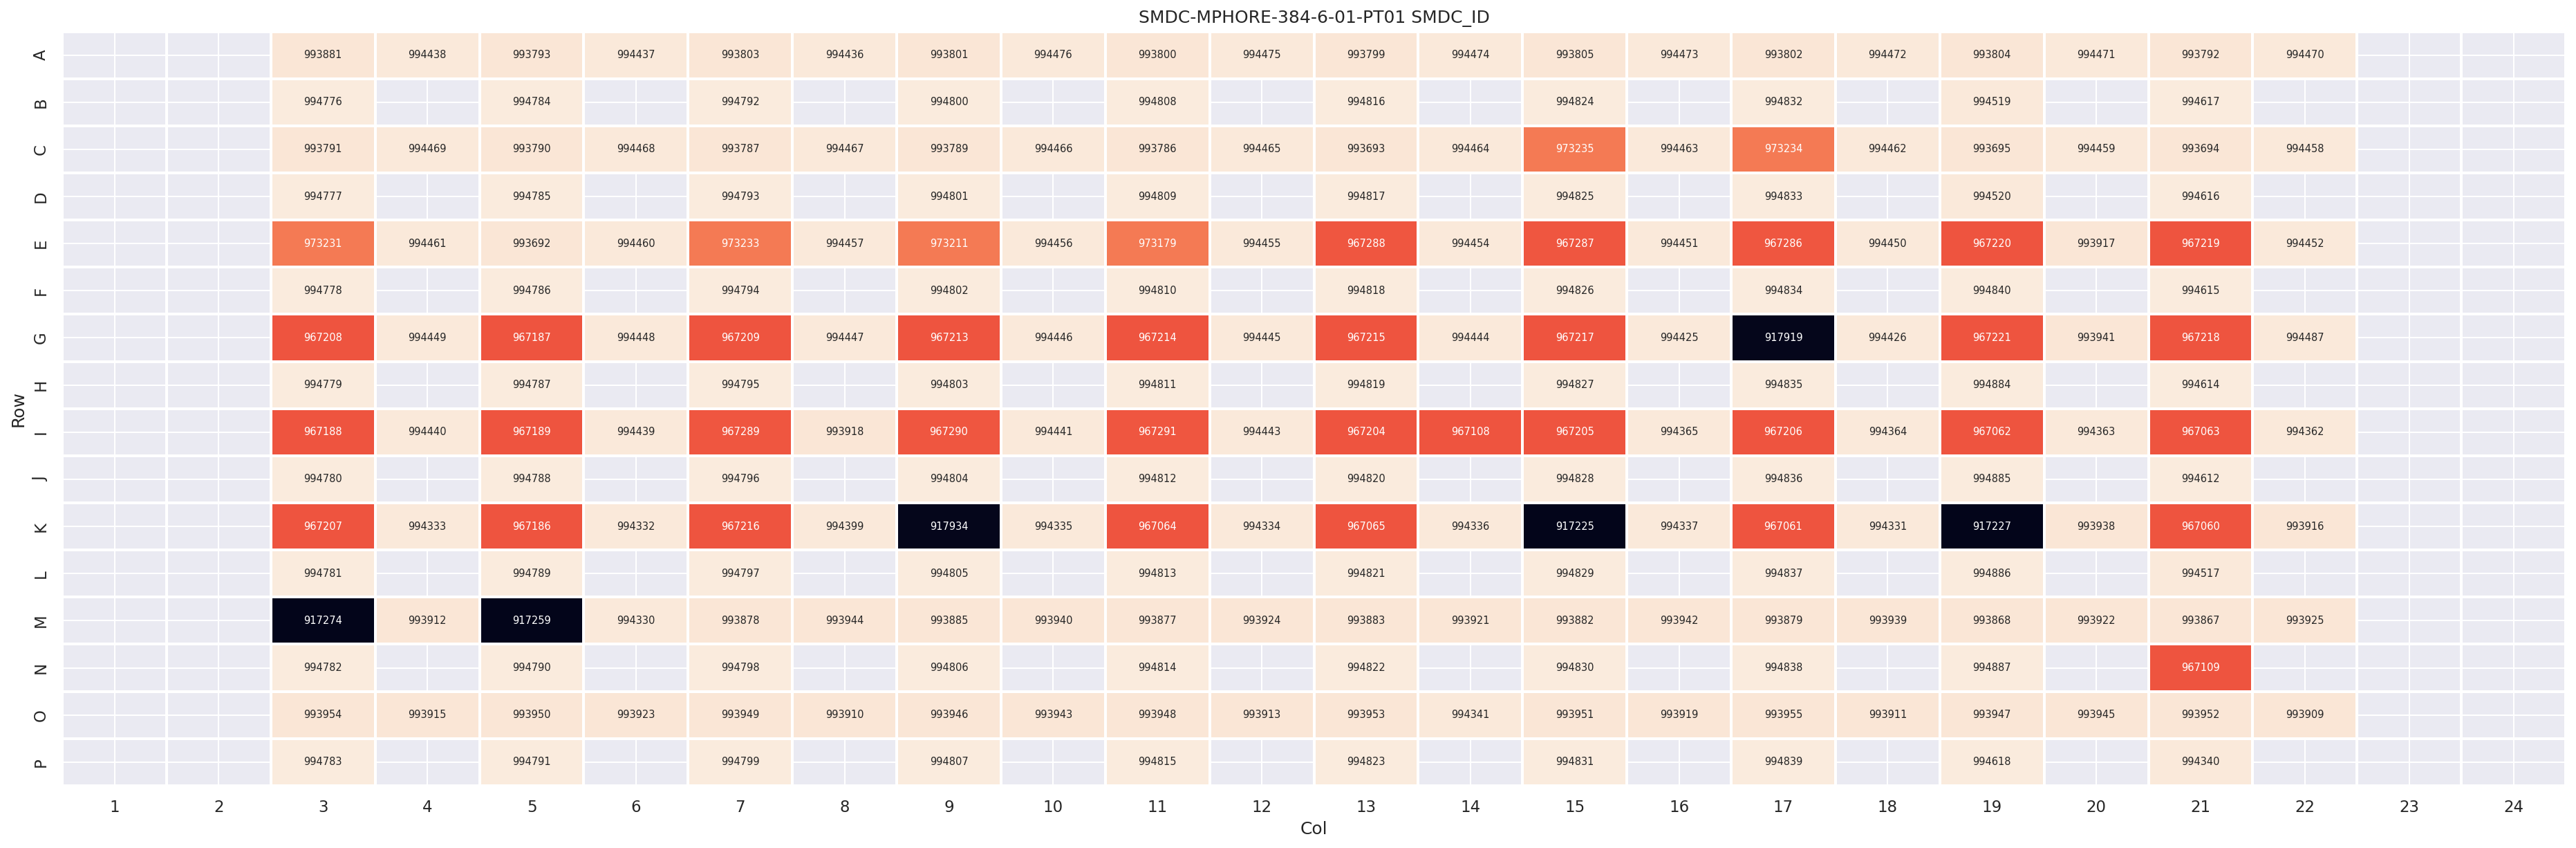

In [7]:
importlib.reload(pm)
pl=pm.make_platemaps_from_barcode(barcode=barcode, outdir=None)
pm.draw_plate_heatmap(barcode=barcode)

In [8]:
if pl.Conc_uM.unique()[0] is None:
    pl.Conc_uM=pl.Conc_nM/1000
pl.head()

,Well,Vendor_Alias,SMDC_ID,Common_Name,Lot_Num,Conc_uM,Conc_nM,SMILES,Row,Col,Plate
0,A01,None,NaN,NaN,None,NaN,None,None,A,1,SMDC-MPHORE-384-6-01-PT01
1,A03,DT95-499-34,993881.0,NaN,1.0,NaN,None,CN(C)CCSSCCNC(=O)[C@H]1CN(C[C@@H]1c2cccnc2)C(=...,A,3,SMDC-MPHORE-384-6-01-PT01
4,A05,DT95-481,993793.0,NaN,1.0,NaN,None,CN(C)CCSSc1ccc(c(c1)C(=O)O)[N+](=O)[O-],A,5,SMDC-MPHORE-384-6-01-PT01
7,A07,DT95-480-37,993803.0,NaN,1.0,NaN,None,COc1cccc(c1)[C@H]2C[C@@H](CN(C2)S(=O)(=O)c3cc(...,A,7,SMDC-MPHORE-384-6-01-PT01
10,A09,DT95-480-29,993801.0,NaN,1.0,NaN,None,CN(C)CCSSCCNC(=O)[C@@H]1CN(C[C@H]1c2oc3ccccc3c...,A,9,SMDC-MPHORE-384-6-01-PT01


In [11]:
df[df.Well=="A13"]

,Sample,Plate,Well,Fname,intensitymax,massatmax,linenum_start,linenum,intensityprint,intensityprotein,...,protein_1reductant_max,protein_1cap_min,protein_1cap_max,intensitytotal,percentlabeled,note,percentsecondary,percentsinglelabeled,spectrashift,signalsignificance
10,11,1,A13,20231001_S136C_APO_P6_A13,1083260.0,16463.0,87279,95281,..-i-..---..-lli.....-il-..................,84.703,...,15567.992175,15586.045175,15596.045175,251.887,66.372619,Percent labeled > 1,0,66.372619,0.0,17.917115


In [12]:
pl=pl.rename(columns={'Plate':'Barcode'})
dfm=df.merge(pl, how='outer', on='Well')
dfm.head(2)

,Sample,Plate,Well,Fname,intensitymax,massatmax,linenum_start,linenum,intensityprint,intensityprotein,...,Vendor_Alias,SMDC_ID,Common_Name,Lot_Num,Conc_uM,Conc_nM,SMILES,Row,Col,Barcode
0,1,1,A03,20231001_S136C_APO_P6_A3,35117.0,15562.0,79,8081,................ill-.--...-llli-.................,811.715,...,DT95-499-34,993881.0,NaN,1.0,NaN,None,CN(C)CCSSCCNC(=O)[C@H]1CN(C[C@@H]1c2cccnc2)C(=...,A,3,SMDC-MPHORE-384-6-01-PT01
1,2,1,A04,20231001_S136C_APO_P6_A4,825781.0,15561.0,8799,16801,..--....-llli-..........-ii-.....................,691.358,...,DT95-586-3,994438.0,NaN,1.0,NaN,None,CN(C)CCSSCCNC(=O)c1ccc2nnc(NC(=O)C3CC3)n2c1,A,4,SMDC-MPHORE-384-6-01-PT01


In [13]:
dfm.loc[dfm.SMDC_ID.isna(), 'percentlabeled']=0

In [14]:
dfm['percentlabeled']=dfm['percentlabeled'].astype(float)

In [15]:
dfm['hmlab']=dfm.percentlabeled.round(1)

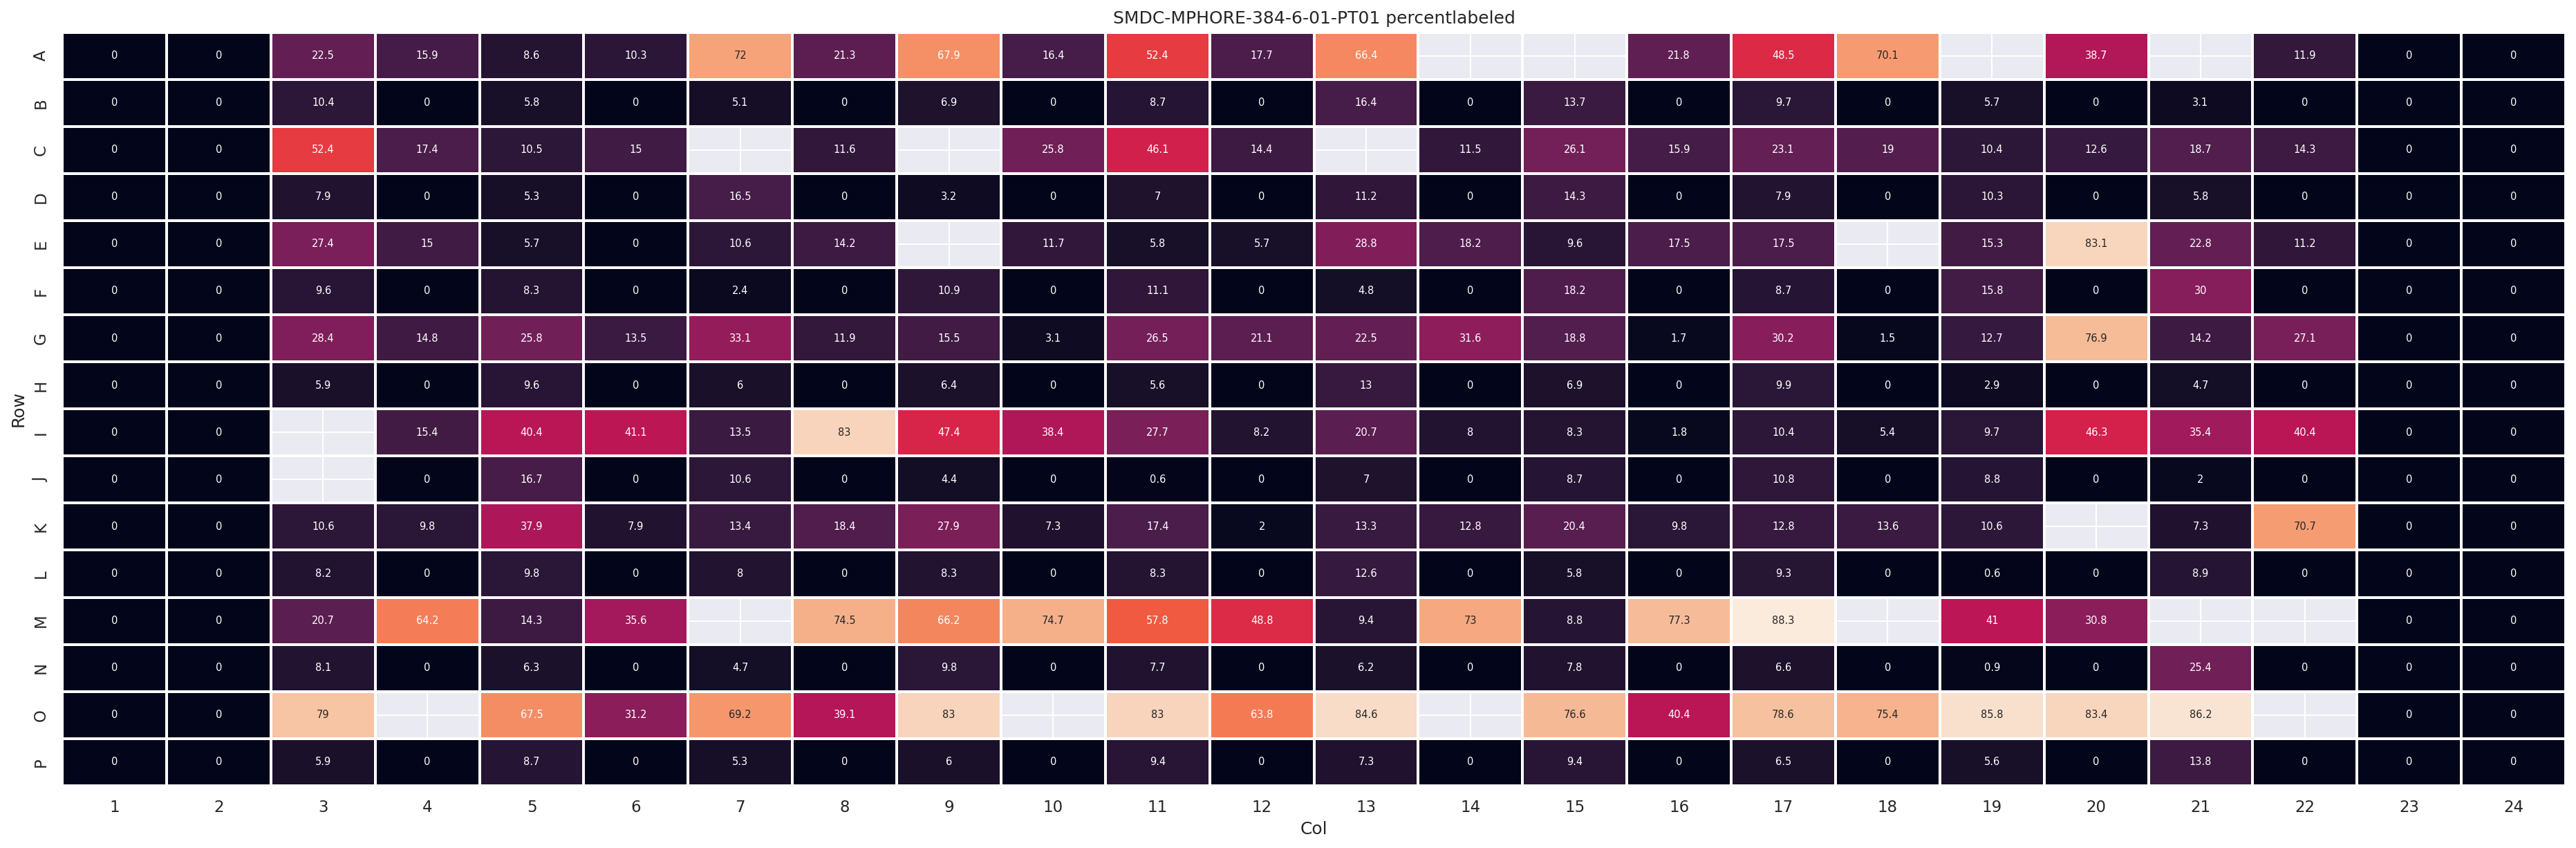

In [16]:
importlib.reload(pm)
pm.draw_plate_heatmap(barcode=barcode, df=dfm, wells='Well', values='percentlabeled', labels='hmlab', center=None, vmin=None, vmax=None, width=25, outdir=None)

In [18]:
smdc=993799
dfm[dfm.ICL_IC_ID==smdc]

,Sample,Plate,Well,Fname,intensitymax,massatmax,linenum_start,linenum,intensityprint,intensityprotein,...,SMDC_ID,Common_Name,Lot_Num,Conc_uM,Conc_nM,SMILES,Row,Col,Barcode,hmlab
10,11,1,A13,20231001_S136C_APO_P6_A13,1083260.0,16463.0,87279,95281,..-i-..---..-lli.....-il-..................,84.703,...,993799.0,NaN,1.0,NaN,None,CN(C)CCSSCCNC(=O)[C@H]1C[C@@H](CN(C1)S(=O)(=O)...,A,13,SMDC-MPHORE-384-6-01-PT01,66.4


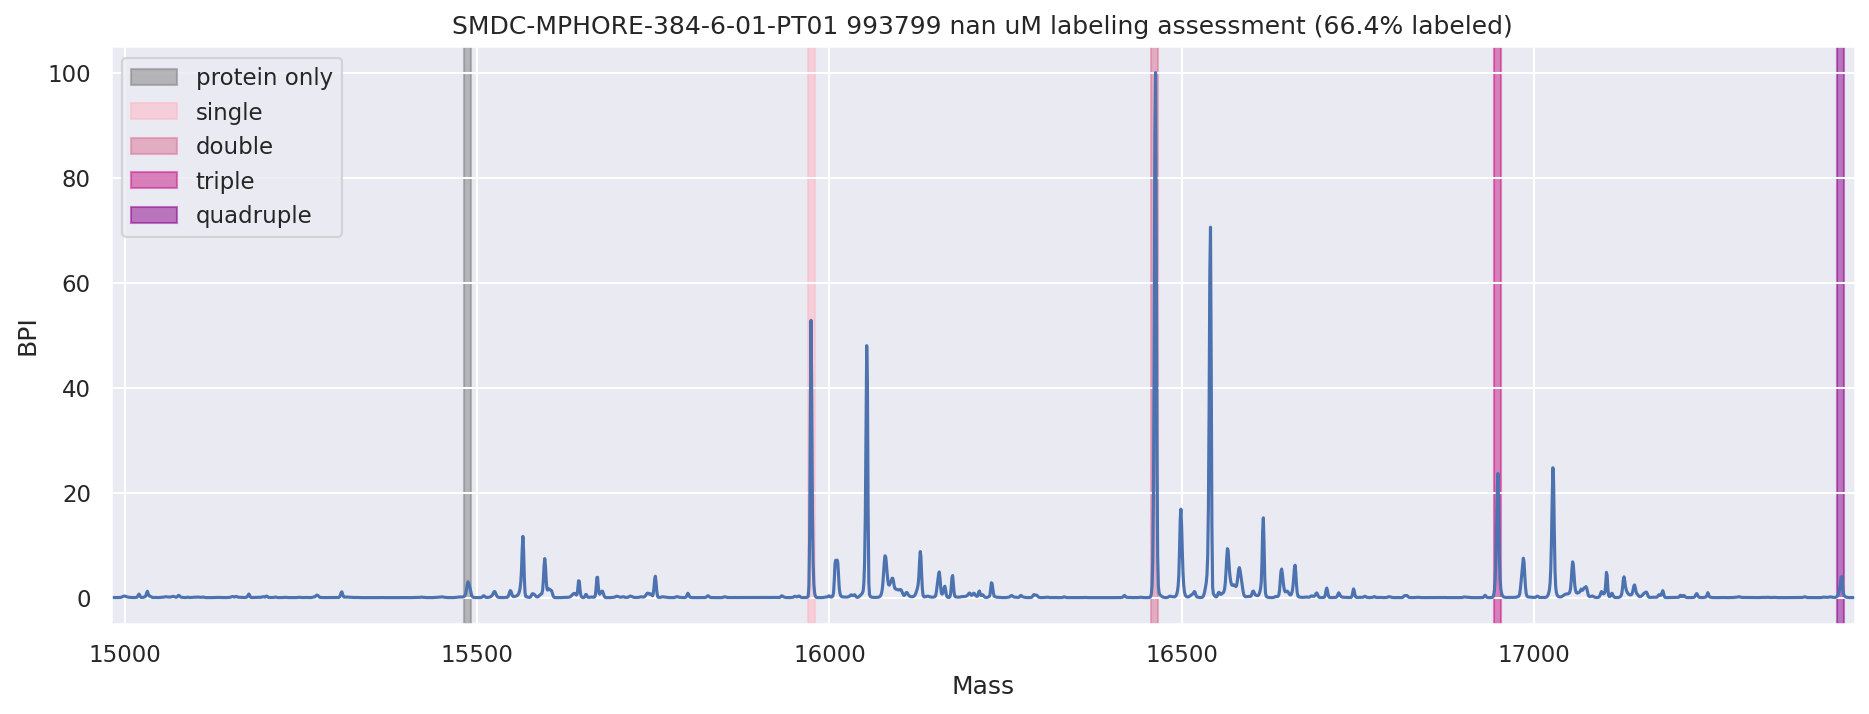

In [19]:
for well in dfm[dfm.ICL_IC_ID==smdc].Well:
    sample=dfm[dfm.Well==well].Sample.iloc[0]
    conc=dfm[dfm.Well==well].Conc_uM.iloc[0]
    conc_unit='uM'
    if conc is None:
        conc=dfm[dfm.Well==well].Conc_nM.iloc[0]
        conc_unit='nM'
    pct=dfm[dfm.Well==well].hmlab.iloc[0]

    dat=pd.read_csv(f'Sample_{str(sample).zfill(3)}_data.txt', sep='\t')
    dat.columns=['Mass','BPI']
    dat=dat.astype(float)
    dat.head(2)

    adduct_mass=df[df.Sample==sample].adduct_mass.astype(float).iloc[0]
    xmin=protein_mass-adduct_mass-4*scan_range
    xmax=protein_mass+4*adduct_mass+4*scan_range

    colors=['gray','lightpink','palevioletred','mediumvioletred','darkmagenta']
    labels=['protein only','single','double','triple','quadruple']
    fig, ax = plt.subplots(1, figsize=(15,5))
    sns.lineplot(data=dat, x='Mass', y='BPI')
    for mult in [0,1,2,3,4]:
        ax.axvspan(protein_mass+mult*adduct_mass-scan_range, protein_mass+mult*adduct_mass+scan_range, color=colors[mult], label=labels[mult], zorder=0, alpha=0.5)
    ax.set_xlim(xmin, xmax)
    ax.legend()
    ax.set_title(f'{barcode} {smdc} {conc} {conc_unit} labeling assessment ({pct}% labeled)');

#     protnums=df.loc[df['Sample']==sample,[x for x in df.columns if 'min' in x]].T
#     protnums=protnums.sort_values(by=protnums.columns[0])
#     protnums=protnums[~protnums[protnums.columns[0]].isna()]
#     cols=protnums.index.tolist()
#     cols=[x.replace('_min','') for x in cols]
#     cols

#     pal=sns.color_palette("viridis", len(cols))
#     fig, ax = plt.subplots(1, figsize=(15,5))
#     sns.lineplot(data=dat, x='Mass', y='BPI')
#     ax.axvspan(protein_mass-scan_range, protein_mass+scan_range, color='gray', label='protein_only', zorder=0, alpha=0.5)
#     for i, lab in enumerate(cols):
#         ax.axvspan(df[df.Sample==sample][f'{lab}_min'].astype(float).iloc[0],
#                    df[df.Sample==sample][f'{lab}_max'].astype(float).iloc[0], 
#                    label=lab, color=pal[i], zorder=0, alpha=0.5)

#     ax.set_xlim(xmin, xmax)
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.set_title(f'{barcode} {smdc} {conc} {conc_unit} labeling assessment');

In [476]:
import numpy as np
import plot_curves as pc

In [496]:
dfm=dfm.sort_values(['Conc_uM','ICL_IC_ID',])

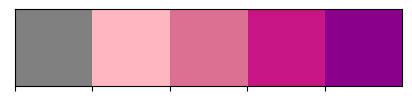

In [497]:
sns.palplot(colors)

In [498]:
smdc=1124895
tmp=dfm[dfm.ICL_IC_ID==smdc].copy()

In [500]:
tmp.percentsecondary

172    5.927114
19     5.653877
173    6.345585
20     5.883449
174    6.418588
21            0
175     6.40388
22            0
176           0
23            0
177           0
24            0
25            0
178           0
179           0
26            0
Name: percentsecondary, dtype: object

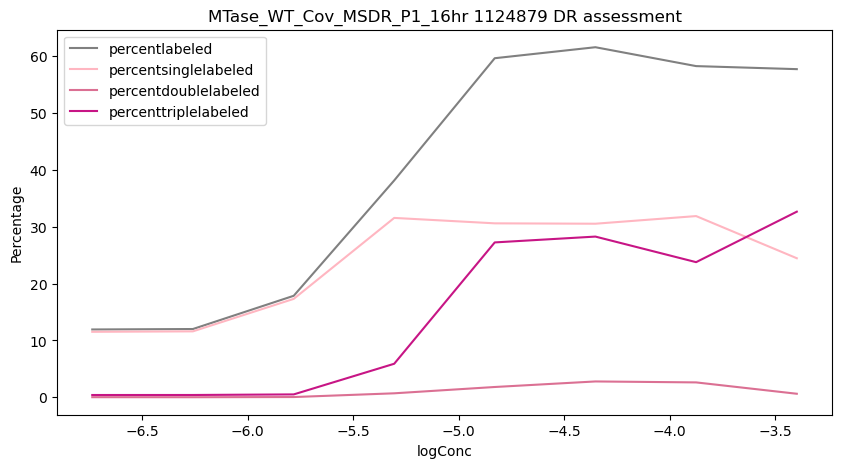

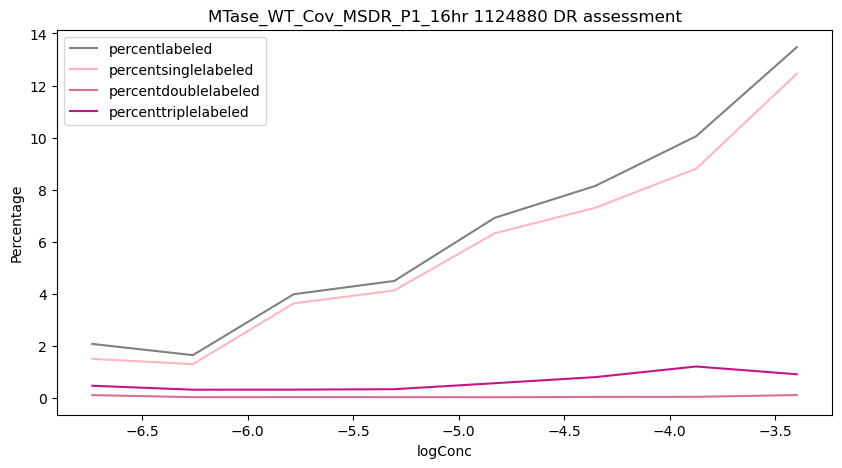

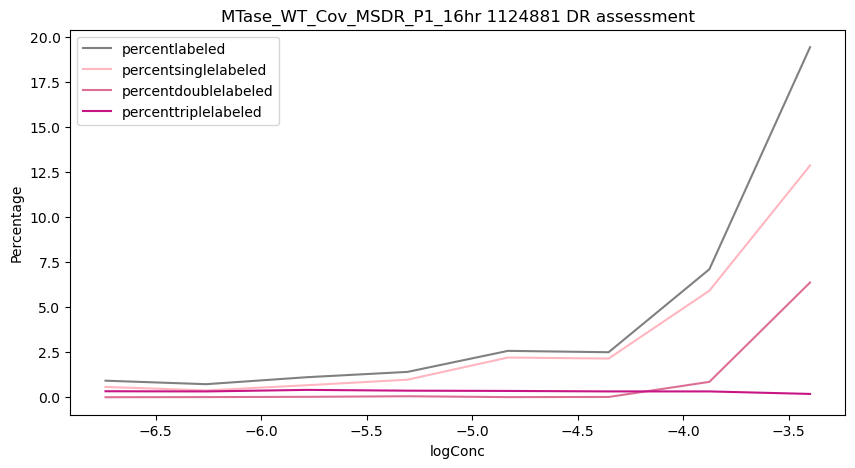

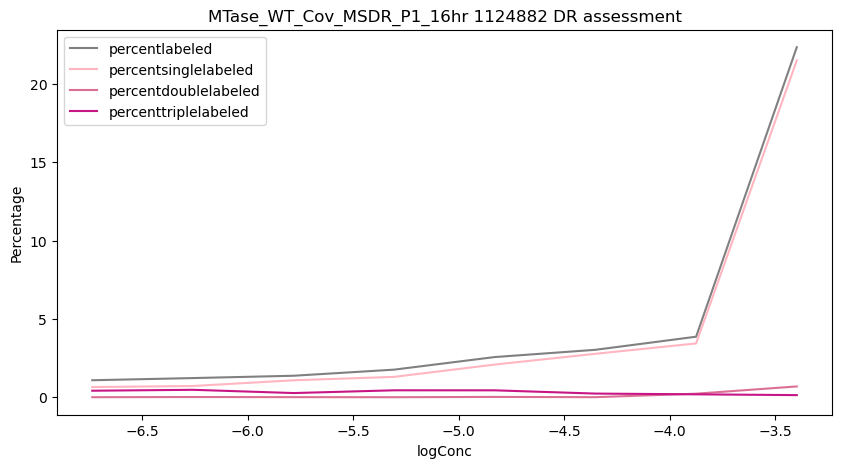

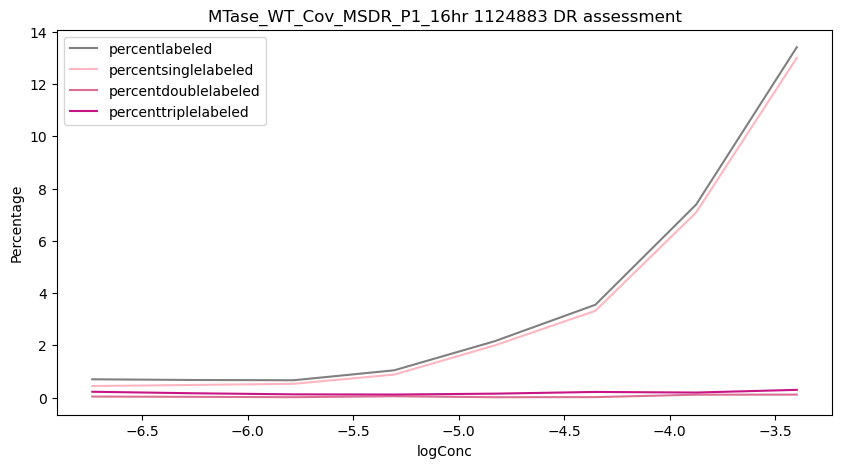

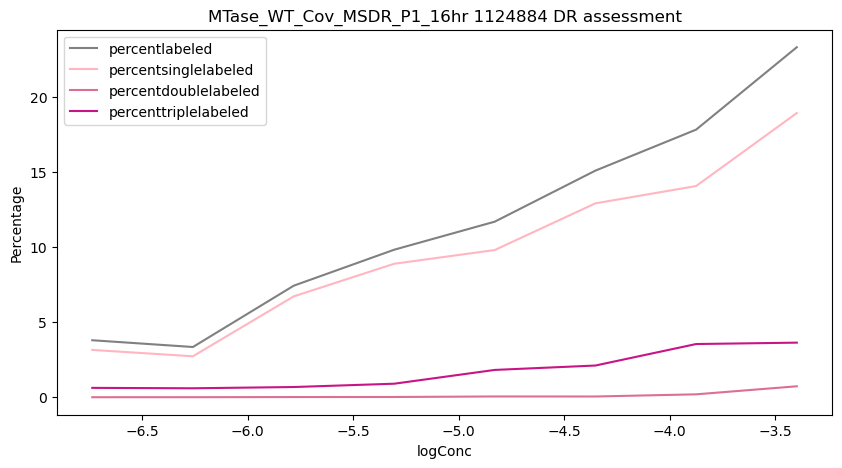

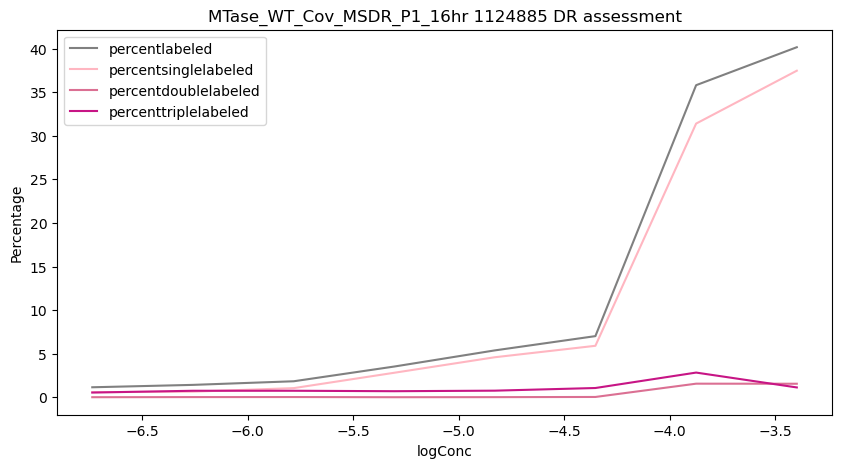

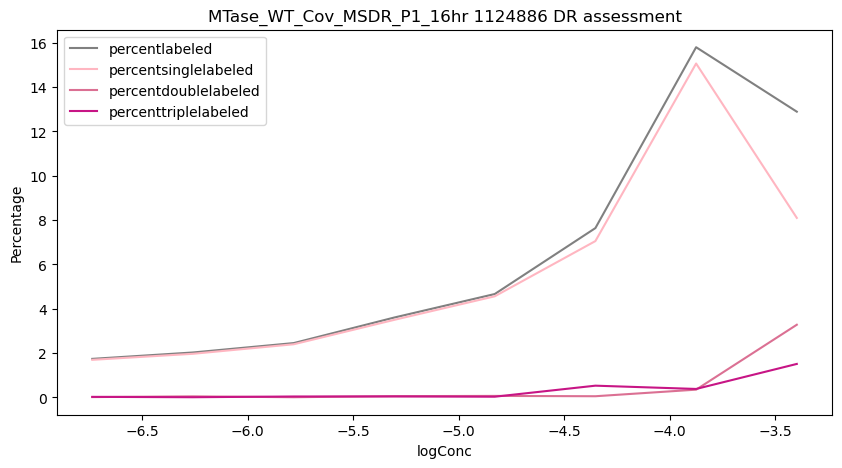

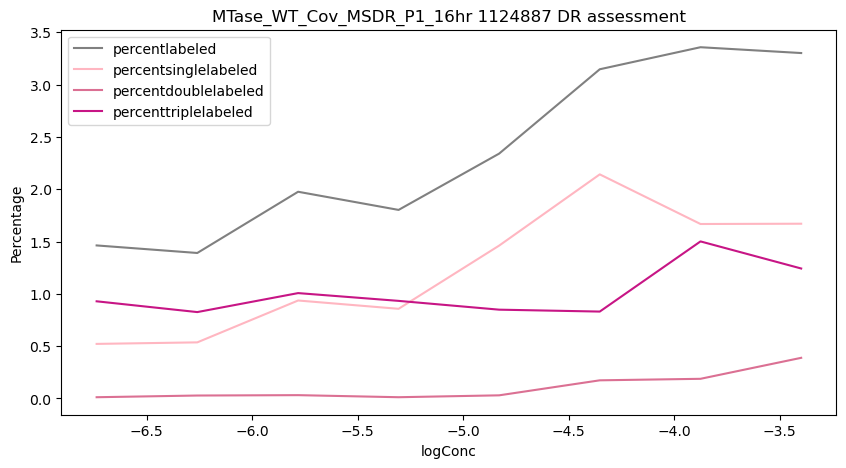

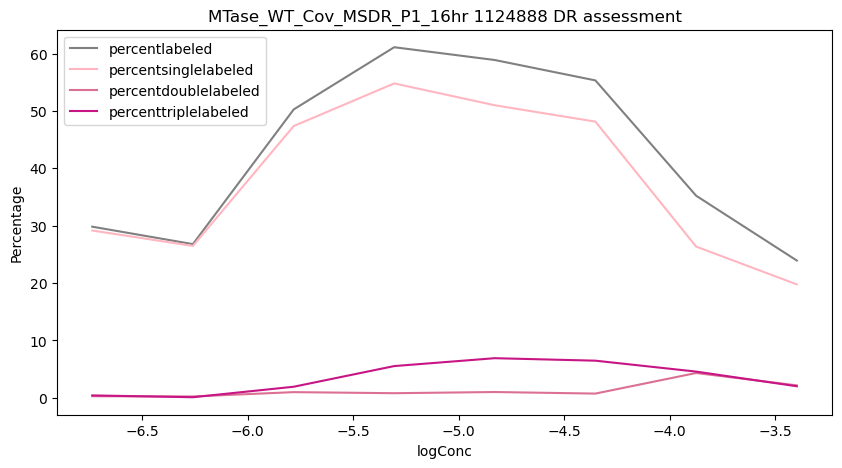

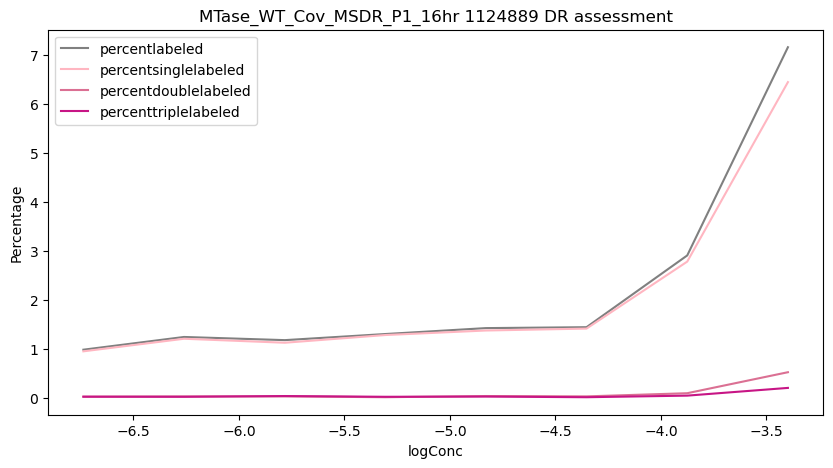

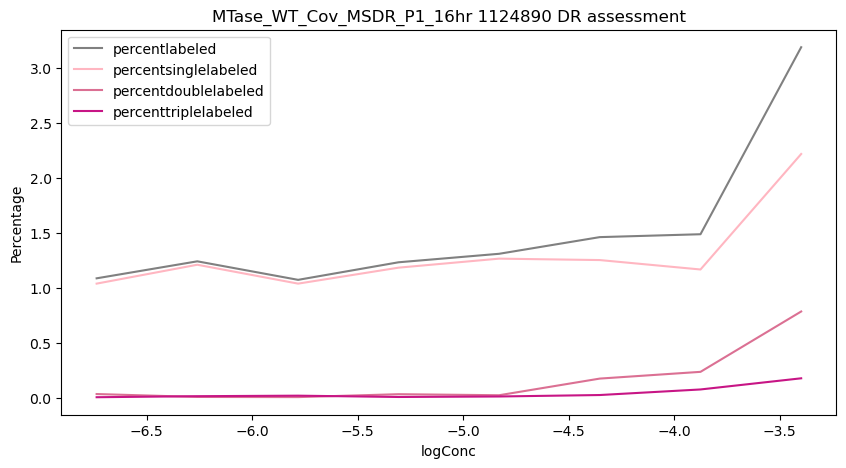

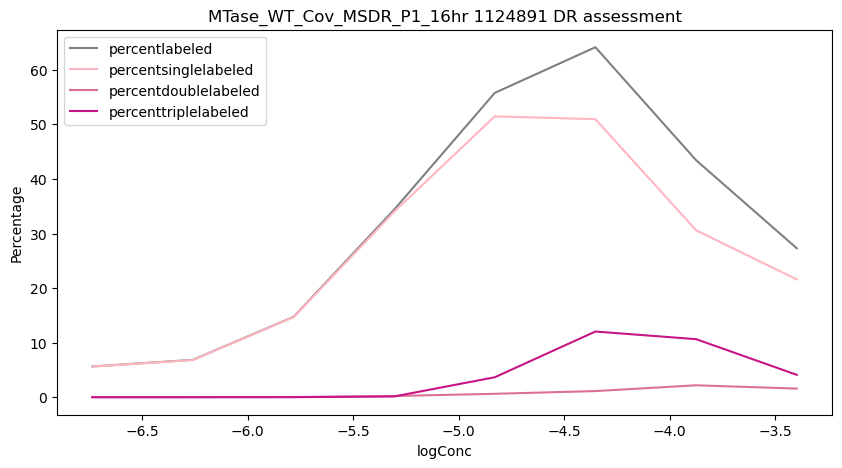

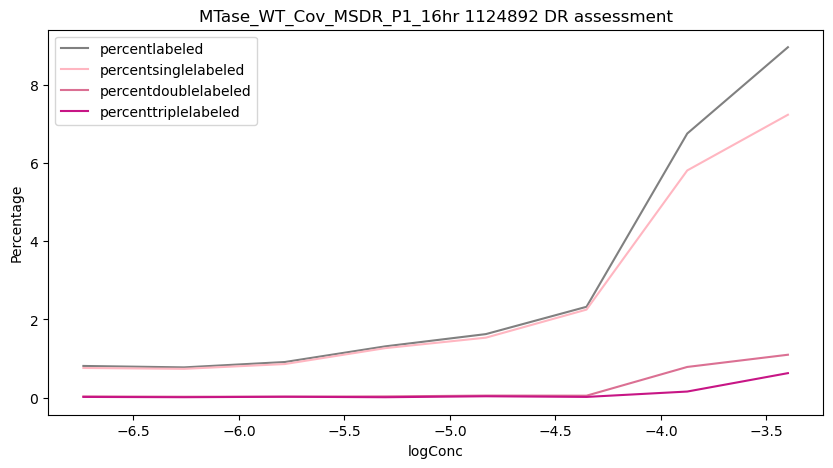

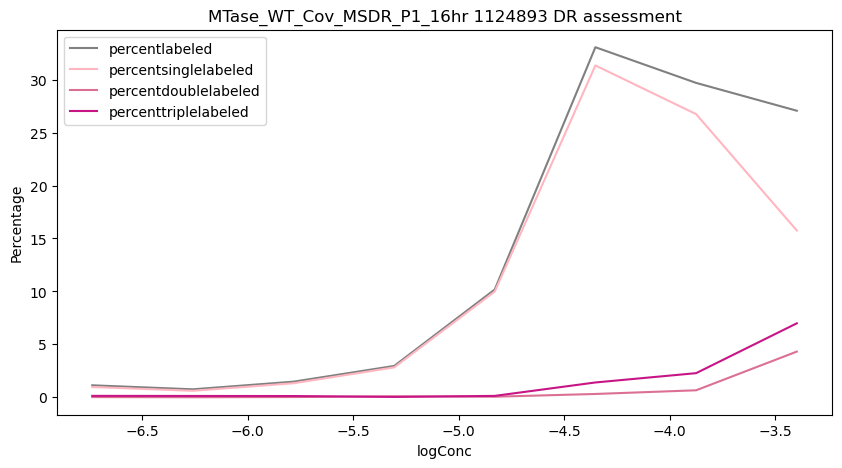

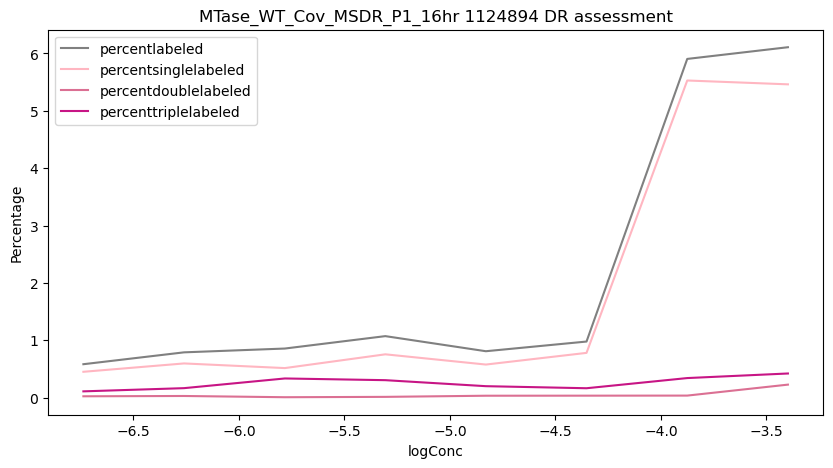

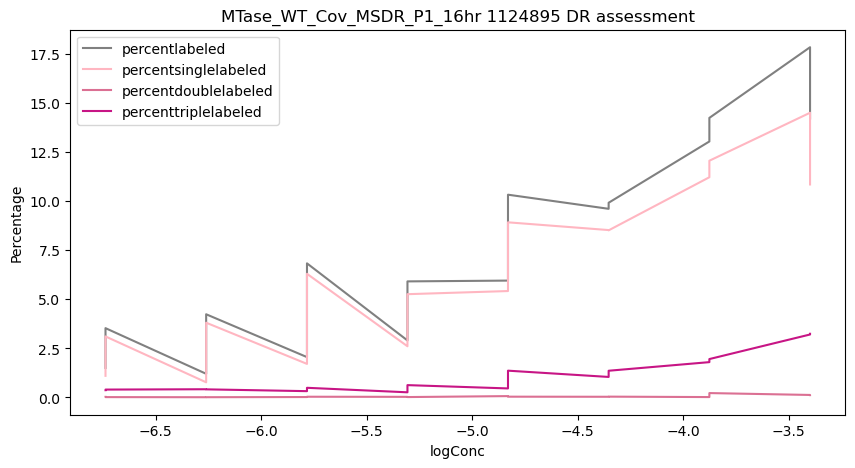

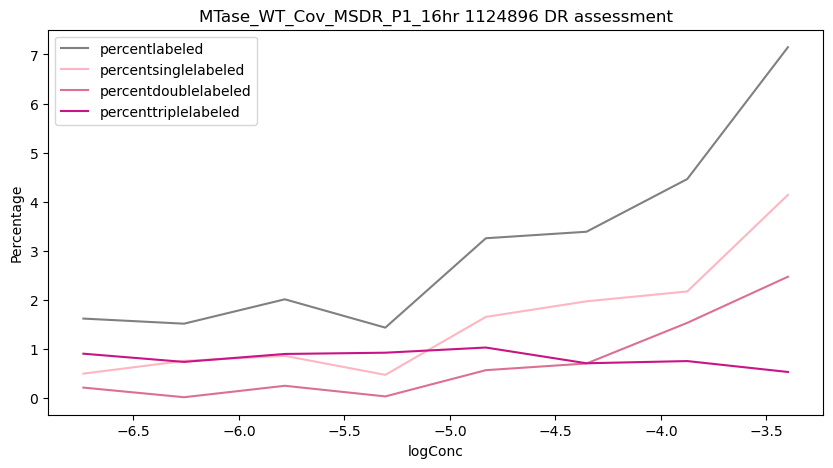

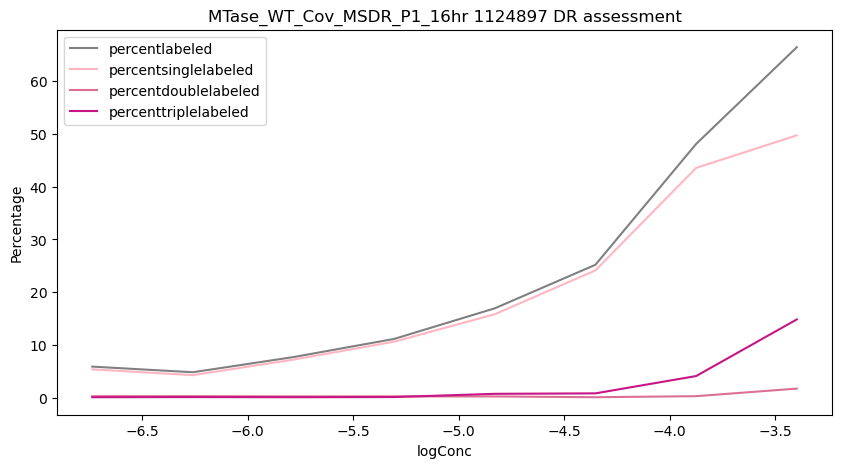

In [485]:
for smdc in dfm.ICL_IC_ID.unique():
    if np.isnan(smdc):
        continue
    tmp=dfm[dfm.ICL_IC_ID==smdc].copy()
    tmp['logConc']=[np.log10(x/1000000) for x in tmp.Conc_uM]

    tmp=tmp[tmp.Conc_uM<500]

    importlib.reload(pc)
    fig, ax = plt.subplots(1, figsize=(10,5))
    for i, lab in enumerate(['percentlabeled','percentsinglelabeled', 'percentdoublelabeled', 'percenttriplelabeled',]):
        # pc.ModelAndScatterPlot(tmp.logConc, tmp[lab], label=lab, ax=ax, color=colors[i], init=[100, -5, -5., 1],
        #                       bounds=([0,-20,-np.inf,-np.inf], [120, 20, np.inf,np.inf]))
        ax.plot(tmp.logConc, tmp[lab], label=lab, color=colors[i])
    ax.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('logConc')
    ax.set_ylabel('Percentage')
    ax.set_title(f'{barcode} {int(smdc)} DR assessment');